# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Utilities

In [2]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

def l1_regularization(model, lambda_l1):
    l1_loss = 0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
    return lambda_l1 * l1_loss

def l2_regularization(model, lambda_l2):
    l2_loss = 0
    for param in model.parameters():
        l2_loss += torch.sum(torch.square(param))
    return lambda_l2 * l2_loss

def train_model(model, criterion, optimizer, X_train, y_train, lambda_l1, lambda_l2):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1)) + l1_regularization(model, lambda_l1) + l2_regularization(model,lambda_l2)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == y_test.view(-1, 1)).sum().item() / len(y_test)
    return accuracy

# $(a)$ 

# Generating Dataset

In [3]:
num_samples = 400
mean = 0
std_dev = 250  
np.random.seed(42)

x1_array = np.random.normal(mean, std_dev, num_samples)
x2_array = np.random.normal(mean, std_dev, num_samples)

Dataset_array = np.column_stack((x1_array,x2_array))
Dataset = torch.tensor(Dataset_array, dtype=torch.float32)


In [4]:
X_train_array = np.array(Dataset[:200,:])
y_train_array = np.where((X_train_array[:,0]*X_train_array[:,1])>0,1,0)

X_test_array = np.array(Dataset[200:,:])
y_test_array = np.where((X_test_array[:,0]*X_test_array[:,1])>0,1,0)

X_train = torch.tensor(X_train_array, dtype=torch.float32)
y_train = torch.tensor(y_train_array, dtype=torch.float32)

X_test = torch.tensor(X_test_array, dtype=torch.float32)
y_test = torch.tensor(y_test_array, dtype=torch.float32)



# Training using convergence method

In [5]:
# model_a = MLP(2,8,4,1)
# criterion = nn.BCELoss()  # Binary Cross Entropy Loss
# optimizer = optim.Adam(model_a.parameters(), lr=0.01)
# prev_loss = 1e8
# converged = False
# # Step 4: Train the model
# num_epochs = 1000
# epoch = 1
# while not converged:
#     optimizer.zero_grad()
#     outputs = model_a(X_train)
#     loss = criterion(outputs, y_train.view(-1, 1))
#     loss.backward()
#     optimizer.step()
    
#     if (epoch+1) % 100 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
#     epoch+=1
    
#     if np.abs(prev_loss - loss.item()) < 1e-6:
#         converged = True
#     prev_loss = loss.item() 

# Training using limited epoch passes

In [6]:
model_a=MLP(2,8,4,1)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model_a.parameters(), lr=0.01)

# Step 4: Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model_a(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 0.0196
Epoch [200/1000], Loss: 0.0126
Epoch [300/1000], Loss: 0.0087
Epoch [400/1000], Loss: 0.0061
Epoch [500/1000], Loss: 0.0043
Epoch [600/1000], Loss: 0.0031
Epoch [700/1000], Loss: 0.0022
Epoch [800/1000], Loss: 0.0016
Epoch [900/1000], Loss: 0.0012
Epoch [1000/1000], Loss: 0.0009


# Testing model

In [7]:
with torch.no_grad():
    predicted = model_a(X_test)
    predicted_classes = predicted.round()
    accuracy = (predicted_classes == y_test.view(-1, 1)).sum().item() / len(y_test)
    accuracy = 100*accuracy
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 98.0000


# Plotting Decision Boundary

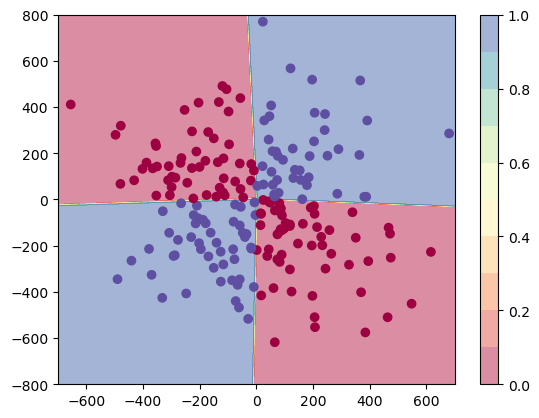

In [31]:
def predict_plot_grid(model):
    XX, YY = torch.meshgrid(torch.linspace(-700, 700, 1000), torch.linspace(-800, 800, 1000))
    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model(X_grid)
    
    probs = logits.reshape(1000, 1000)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()

    
    plt.scatter(X_train[:, 0].detach().numpy(), X_train[:, 1].detach().numpy(),c=y_train, cmap=plt.cm.Spectral)
    
predict_plot_grid(model_a)

# $(b)$

# Optimising lambda for L1 regularisation using Validation

In [9]:
# Define hyperparameters
input_size = 2
hidden_size1 = 8
hidden_size2 = 4
output_size = 1
learning_rate = 0.01
num_epochs = 100

# Define penalty coefficients to try
lambda_values = np.array(range(5,101,5))
lambda_values = lambda_values/100

# Train the model with different penalty coefficients
best_accuracy = 0
best_lambda_l1 = None
for lambda_ in lambda_values:
    model_l1_lambda = MLP(input_size, hidden_size1, hidden_size2, output_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model_l1_lambda.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=np.random.randint(100))
        
        inputs = X_training
        labels = y_training

        loss = train_model(model_l1_lambda, criterion, optimizer, inputs, labels, lambda_, 0)
        
        accuracy = evaluate_model(model_l1_lambda, X_validation, y_validation)
        print(f"Lambda: {lambda_}, Test accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lambda_l1 = lambda_

print("Best lambda:", best_lambda_l1)
print("Best accuracy:", best_accuracy)


Lambda: 0.05, Test accuracy: 0.64
Lambda: 0.05, Test accuracy: 0.62
Lambda: 0.05, Test accuracy: 0.64
Lambda: 0.05, Test accuracy: 0.54
Lambda: 0.05, Test accuracy: 0.72
Lambda: 0.05, Test accuracy: 0.66
Lambda: 0.05, Test accuracy: 0.6
Lambda: 0.05, Test accuracy: 0.7
Lambda: 0.05, Test accuracy: 0.72
Lambda: 0.05, Test accuracy: 0.58
Lambda: 0.05, Test accuracy: 0.66
Lambda: 0.05, Test accuracy: 0.7
Lambda: 0.05, Test accuracy: 0.68
Lambda: 0.05, Test accuracy: 0.66
Lambda: 0.05, Test accuracy: 0.68
Lambda: 0.05, Test accuracy: 0.66
Lambda: 0.05, Test accuracy: 0.78
Lambda: 0.05, Test accuracy: 0.88
Lambda: 0.05, Test accuracy: 0.98
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test accuracy: 1.0
Lambda: 0.05, Test accuracy: 1.0
Lambda: 0.05, Test accuracy: 1.0
Lambda: 0.05, Test accuracy: 0.98
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test accuracy: 0.98
Lambda: 0.05, Test accuracy: 0.98
Lambda: 0.05, Test accuracy: 0.98
Lambda: 0.05, Test accuracy: 0.98
Lambda: 0.05, Test a

# Training Model

In [10]:
model_l1 = MLP(2,8,4,1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_l1.parameters(), lr=learning_rate)
l1_regularization(model_l1,best_lambda_l1)

# best lambda came out to be 0.05
num_epochs = 2000
for epoch in range(num_epochs):
    loss = train_model(model_l1, criterion, optimizer, inputs, labels, best_lambda_l1, 0)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

Epoch [100/2000], Loss: 0.4576
Epoch [200/2000], Loss: 0.3411
Epoch [300/2000], Loss: 0.2997
Epoch [400/2000], Loss: 0.2835
Epoch [500/2000], Loss: 0.2753
Epoch [600/2000], Loss: 0.2734
Epoch [700/2000], Loss: 0.2723
Epoch [800/2000], Loss: 0.2701
Epoch [900/2000], Loss: 0.2699
Epoch [1000/2000], Loss: 0.2695
Epoch [1100/2000], Loss: 0.2689
Epoch [1200/2000], Loss: 0.2689
Epoch [1300/2000], Loss: 0.2692
Epoch [1400/2000], Loss: 0.2685
Epoch [1500/2000], Loss: 0.2685
Epoch [1600/2000], Loss: 0.2689
Epoch [1700/2000], Loss: 0.2685
Epoch [1800/2000], Loss: 0.2685
Epoch [1900/2000], Loss: 0.2684
Epoch [2000/2000], Loss: 0.2685


# Testing Model

In [11]:
with torch.no_grad():
    predicted = model_l1(X_test)
    predicted_classes = predicted.round()
    accuracy = (predicted_classes == y_test.view(-1, 1)).sum().item() / len(y_test)
    accuracy = 100*accuracy
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 98.5000


# Plotting Decision Boundary

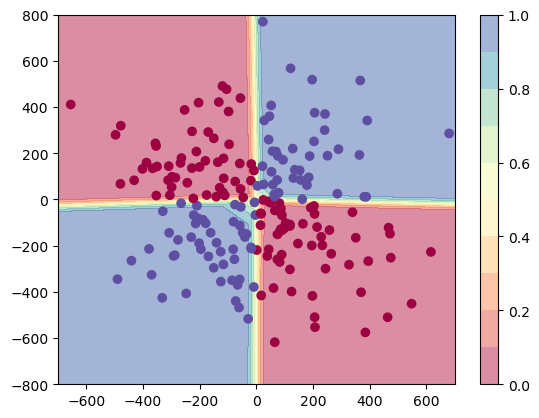

In [12]:
def predict_plot_grid(model):
    XX, YY = torch.meshgrid(torch.linspace(-700, 700, 1000), torch.linspace(-800, 800, 1000))
    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model(X_grid)
    
    probs = logits.reshape(1000, 1000)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()

    
    plt.scatter(X_train[:, 0].detach().numpy(), X_train[:, 1].detach().numpy(),c=y_train, cmap=plt.cm.Spectral)
    
predict_plot_grid(model_l1)

# $(c)$

# Optimising lambda for L2 regularisation using Validation

In [13]:
# Define hyperparameters
input_size = 2
hidden_size1 = 8
hidden_size2 = 4
output_size = 1
learning_rate = 0.01
num_epochs = 100

# Define penalty coefficients to try
lambda_values = np.array(range(5,101,5))
lambda_values = lambda_values/100

# Train the model with different penalty coefficients
best_accuracy = 0
best_lambda_l2 = None
for lambda_ in lambda_values:
    model_l2_lambda = MLP(input_size, hidden_size1, hidden_size2, output_size)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model_l2_lambda.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=np.random.randint(100))
        
        inputs = X_training
        labels = y_training

        loss = train_model(model_l2_lambda, criterion, optimizer, inputs, labels, 0, lambda_)
        
        accuracy = evaluate_model(model_l2_lambda, X_validation, y_validation)
        print(f"Lambda: {lambda_}, Test accuracy: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lambda_l2 = lambda_

print("Best lambda:", best_lambda_l2)
print("Best accuracy:", best_accuracy)


Lambda: 0.05, Test accuracy: 0.6
Lambda: 0.05, Test accuracy: 0.68
Lambda: 0.05, Test accuracy: 0.6
Lambda: 0.05, Test accuracy: 0.64
Lambda: 0.05, Test accuracy: 0.7
Lambda: 0.05, Test accuracy: 0.62
Lambda: 0.05, Test accuracy: 0.62
Lambda: 0.05, Test accuracy: 0.6
Lambda: 0.05, Test accuracy: 0.64
Lambda: 0.05, Test accuracy: 0.5
Lambda: 0.05, Test accuracy: 0.6
Lambda: 0.05, Test accuracy: 0.64
Lambda: 0.05, Test accuracy: 0.72
Lambda: 0.05, Test accuracy: 0.68
Lambda: 0.05, Test accuracy: 0.74
Lambda: 0.05, Test accuracy: 0.72
Lambda: 0.05, Test accuracy: 0.74
Lambda: 0.05, Test accuracy: 0.72
Lambda: 0.05, Test accuracy: 0.88
Lambda: 0.05, Test accuracy: 0.68
Lambda: 0.05, Test accuracy: 0.7
Lambda: 0.05, Test accuracy: 0.72
Lambda: 0.05, Test accuracy: 0.84
Lambda: 0.05, Test accuracy: 0.72
Lambda: 0.05, Test accuracy: 0.94
Lambda: 0.05, Test accuracy: 0.88
Lambda: 0.05, Test accuracy: 0.94
Lambda: 0.05, Test accuracy: 0.88
Lambda: 0.05, Test accuracy: 0.96
Lambda: 0.05, Test ac

# Training

In [14]:
model_l2 = MLP(2,8,4,1)
criterion = nn.BCELoss()
optimizer = optim.Adam(model_l2.parameters(), lr=learning_rate)


num_epochs = 1000
for epoch in range(num_epochs):
    loss = train_model(model_l2, criterion, optimizer, inputs, labels, 0, best_lambda_l2)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

Epoch [100/1000], Loss: 0.2860
Epoch [200/1000], Loss: 0.2217
Epoch [300/1000], Loss: 0.2026
Epoch [400/1000], Loss: 0.1946
Epoch [500/1000], Loss: 0.1903
Epoch [600/1000], Loss: 0.1878
Epoch [700/1000], Loss: 0.1862
Epoch [800/1000], Loss: 0.1852
Epoch [900/1000], Loss: 0.1845
Epoch [1000/1000], Loss: 0.1841


# Testing

In [15]:
with torch.no_grad():
    predicted = model_l2(X_test)
    predicted_classes = predicted.round()
    accuracy = (predicted_classes == y_test.view(-1, 1)).sum().item() / len(y_test)
    accuracy = 100*accuracy
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 98.0000


# Plotting Decision Boundary

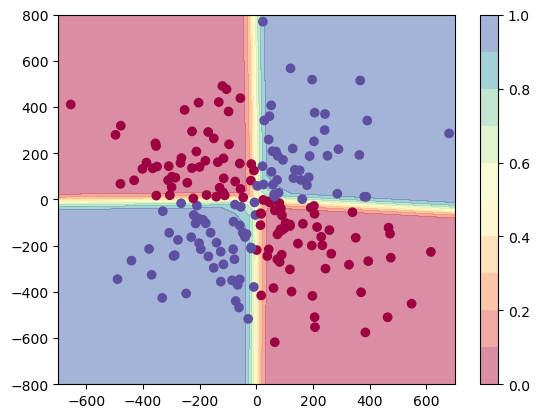

In [16]:
def predict_plot_grid(model):
    XX, YY = torch.meshgrid(torch.linspace(-700, 700, 1000), torch.linspace(-800, 800, 1000))
    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model(X_grid)
    
    probs = logits.reshape(1000, 1000)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()

    
    plt.scatter(X_train[:, 0].detach().numpy(), X_train[:, 1].detach().numpy(),c=y_train, cmap=plt.cm.Spectral)
    
predict_plot_grid(model_l2)

# $(d)$

# Defining new features

In [17]:
#defining new features
x3_array = np.array(x1_array*x2_array)
x4_array = np.array(np.square(x1_array))
x5_array = np.array(np.square(x2_array))
Dataset_array = np.column_stack((x1_array,x2_array,x3_array,x4_array,x5_array))

In [18]:
x1 = torch.tensor(x1_array, dtype=torch.float32)
x2 = torch.tensor(x2_array, dtype=torch.float32)
x3 = torch.tensor(x3_array, dtype=torch.float32)
x4 = torch.tensor(x4_array, dtype=torch.float32)
x5 = torch.tensor(x5_array, dtype=torch.float32)

In [19]:
X_train_array = np.array(Dataset[:200,:])
y_train_array = np.where((X_train_array[:,0]*X_train_array[:,1])>0,1,0)

X_test_array = np.array(Dataset[200:,:])
y_test_array = np.where((X_test_array[:,0]*X_test_array[:,1])>0,1,0)

In [20]:
X_train = torch.tensor(X_train_array, dtype=torch.float32)
y_train = torch.tensor(y_train_array, dtype=torch.float32)

X_test = torch.tensor(X_test_array, dtype=torch.float32)
y_test = torch.tensor(y_test_array, dtype=torch.float32)

Dataset = torch.tensor(Dataset_array, dtype = torch.float32)

# Model 1 with only x1 and x2

In [21]:
#features used are x1 x2 only
X = np.column_stack((x1,x2))
X_train_1 = X[:200,:] 
X_test_1 = X[200:,:]
model_logistic_1 = LogisticRegression(penalty='none')
model_logistic_1.fit(X_train_1,y_train)

/Users/himanshuk/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

In [22]:
predicted_labels = model_logistic_1.predict(X_test_1)
true_labels = y_test
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy*100)

Accuracy: 56.00000000000001


# Plotting Decision Boundary

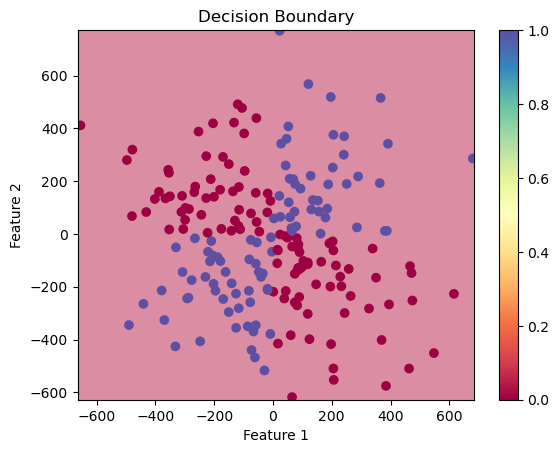

In [23]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
    y_min, y_max = X[:, 1].min() - 10, X[:, 1].max() + 10
    h = 10  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    xx1 = np.square(xx)
    xx2 = np.square(yy)
    xx3 = np.multiply(xx,yy)

    # Predict the function value for the whole grid
    Z = model.predict(np.column_stack([xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.colorbar()
    plt.show()

# Example usage:
plot_decision_boundary(model_logistic_1, X_train_1, y_train)

# Model 2 with only x1 $\cdot$ x2

In [24]:
#features used is x1.x2 only
X = x3
X_train_2 = X[:200] 
X_test_2 = X[200:]
model_logistic_2 = LogisticRegression(penalty='none')
model_logistic_2.fit(X_train_2.reshape(-1, 1),y_train)

/Users/himanshuk/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

In [25]:
predicted_labels = model_logistic_2.predict(X_test_2.reshape(-1, 1))
true_labels = y_test

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy*100)

Accuracy: 100.0


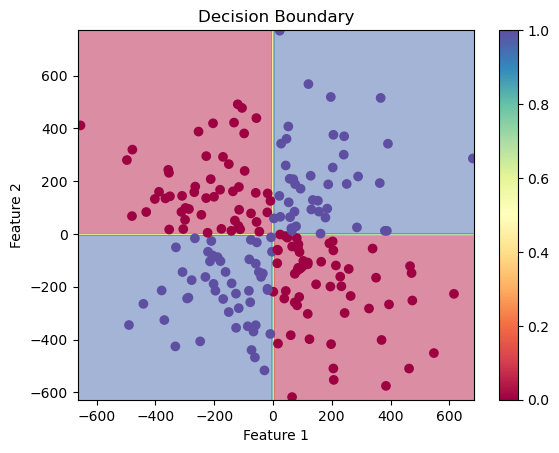

In [26]:
def plot_decision_boundary(model, X1, y):
    # Set min and max values and give it some padding
    x_min, x_max = X1[:, 0].min() - 10, X1[:, 0].max() + 10
    y_min, y_max = X1[:, 1].min() - 10, X1[:, 1].max() + 10
    h = 10  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    xx1 = np.square(xx)
    xx2 = np.square(yy)
    xx3 = np.multiply(xx,yy)

    # Predict the function value for the whole gri
    Z = model.predict(xx3.reshape(-1, 1))
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], alpha=0.5)
    plt.scatter(X1[:, 0], X1[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.colorbar()
    plt.show()

# Example usage:
plot_decision_boundary(model_logistic_2, X_train_1, y_train)

# Model 3 with only x1, x2, $x1^{2}$, $x2^{2}$

In [34]:
#using features x1, x2, x1**2, x2**2
X = np.column_stack((x1,x2,x4,x5))
X_train_3 = X[:200,:] 
X_test_3 = X[200:,:]
model_logistic_3 = LogisticRegression(penalty='none')
model_logistic_3.fit(X_train_3,y_train)

/Users/himanshuk/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(penalty='none')

In [35]:
predicted_labels = model_logistic_3.predict(X_test_3)
true_labels = y_test

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy*100)

Accuracy: 55.00000000000001


# Plotting Decision Boundary

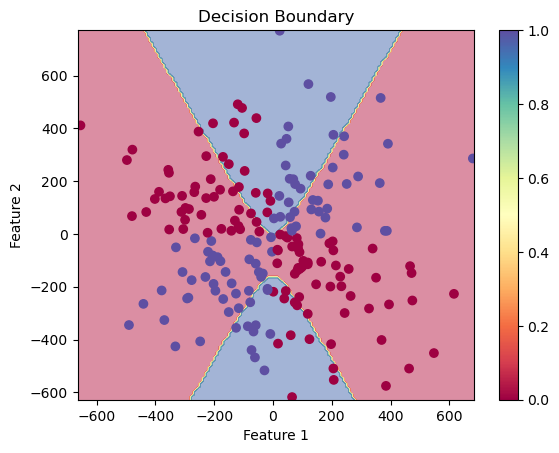

In [29]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
    y_min, y_max = X[:, 1].min() - 10, X[:, 1].max() + 10
    h = 10  # step size in the mesh

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    xx1 = np.square(xx)
    xx2 = np.square(yy)
    xx3 = np.multiply(xx,yy)

    # Predict the function value for the whole grid
    Z = model.predict(np.column_stack([xx.ravel(), yy.ravel(), xx1.ravel(), xx2.ravel()]))
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.colorbar()
    plt.show()

# Example usage:
plot_decision_boundary(model_logistic_3, X_train_3, y_train)

# Dump

In [30]:
# # Dataset 1
# np.random.seed(0)
# X_train_array = np.random.choice([0, 1], size=(200, 2))
# X_train = torch.tensor(X_train_array, dtype=torch.float32)
# y_train = torch.tensor(np.logical_xor(X_train_array[:, 0], X_train_array[:, 1]).astype(int), dtype=torch.float32)

# X_test_array = np.random.choice([0, 1], size=(200, 2))
# X_test = torch.tensor(X_test_array, dtype=torch.float32)
# y_test = torch.tensor((np.logical_xor(X_test_array[:, 0], X_test_array[:, 1])).astype(int), dtype=torch.float32)
# model_01=MLP(2,8,4,1)
# criterion = nn.BCELoss()  # Binary Cross Entropy Loss
# optimizer = optim.Adam(model_01.parameters(), lr=0.01)

# # Step 4: Train the model
# num_epochs = 1000
# for epoch in range(num_epochs):
#     optimizer.zero_grad()
#     outputs = model_01(X_train)
#     loss = criterion(outputs, y_train.view(-1, 1))
#     loss.backward()
#     optimizer.step()

#     if (epoch+1) % 100 == 0:
#         print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Step 5: Evaluate the trained model
# with torch.no_grad():
#     predicted = model_01(X_test)
#     predicted_classes = predicted.round()
#     accuracy = (predicted_classes == y_test.view(-1, 1)).sum().item() / len(y_test)
#     accuracy = 100*accuracy
#     print(f'Test Accuracy: {accuracy:.4f}')
# with torch.no_grad():
#     xor_x = torch.tensor([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
#     y_hat =np.array(model_01(xor_x)>0.5).astype(int)
#     print(y_hat)
